# Baseline model based on anatomy features

In [1]:
path = ".."

import sys
sys.path.insert(0, path)

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

In [3]:
from problem import get_train_data, get_test_data

data_train_, labels_train_ = get_train_data(path=path)
data_test_, labels_test_ = get_test_data(path=path)

## Preprocess input data

Join train and test

In [4]:
data_train = pd.concat([data_train_, pd.Series(labels_train_, index=data_train_.index, name='target')], axis=1)
data_test = pd.concat([data_test_, pd.Series(labels_test_, index=data_test_.index, name='target')], axis=1)

data_train.loc[:, 'is_train'] = 1
data_test.loc[:, 'is_train'] = 0

data = pd.concat([data_train, data_test], axis=0)

In [5]:
data['participants_sex'] = data['participants_sex'].map({'F': -1.0, 'M': +1.0}) 
accepted_anatomy = data['anatomy_select'] < 2

In [6]:
data.shape

(1150, 222)

Remove poor QA data

In [7]:
data1 = data[accepted_anatomy].copy()
data1.shape

(948, 222)

In [8]:
import re 

left_cols = sorted([col for col in data1.columns if col.startswith('anatomy') and re.match(r".+(lh|Left)", col)])

left_cols.remove('anatomy_Left-WM-hypointensities')
left_cols.remove('anatomy_Left-non-WM-hypointensities')

right_cols = []
for c in left_cols:
    if "lh" in c:
        c = c.replace("lh", "rh")
    elif "Left" in c:
        c = c.replace("Left", "Right")
    right_cols.append(c)

anatomy_LR_diff_cols = [(c1, c2) for c1, c2 in zip(left_cols, right_cols)]

In [9]:
to_remove_anatomy_features = [
    'anatomy_Left-WM-hypointensities',
    'anatomy_Left-non-WM-hypointensities',
    'anatomy_Right-WM-hypointensities',
    'anatomy_Right-non-WM-hypointensities',
    'anatomy_5th-Ventricle', 
    'anatomy_non-WM-hypointensities',
    # Correlated with others
    'anatomy_EstimatedTotalIntraCranialVol',
    'anatomy_SupraTentorialVolNotVentVox',
    # Remove correlated L <-> R
    'anatomy_Right-Caudate',
    'anatomy_Right-Cerebellum-Cortex',
    'anatomy_Right-Putamen',
    'anatomy_Right-VentralDC',
    'anatomy_rhCerebralWhiteMatterVol',
    'anatomy_rhCortexVol',
    'anatomy_rhSurfaceHoles',
    'anatomy_rh_MeanThickness_thickness',
    'anatomy_rh_WhiteSurfArea_area',
    'anatomy_rh_superiorparietal_thickness',
]

compute_diff_and_remove_first_anatomy_features = [
    ('anatomy_SubCortGrayVol', 'anatomy_BrainSegVol'),    
    ('anatomy_TotalGrayVol', 'anatomy_CortexVol'),    
]

In [10]:
anatomy_cols = [col for col in data1.columns if col.startswith('anatomy')]

anatomy_cols.remove('anatomy_select')

for c in to_remove_anatomy_features:
    anatomy_cols.remove(c)

participant_cols = [col for col in data1.columns if col.startswith('participant')]
participant_cols.remove('participants_site')

In [11]:
len(anatomy_cols)

189

In [12]:
anatomy_diff_cols = []
to_remove_anatomy_diff_cols = []


for c1, c2 in anatomy_LR_diff_cols:
    data1.loc[:, "{} - {}".format(c1, c2)] = data1[c1] - data1[c2]
    anatomy_diff_cols.append("{} - {}".format(c1, c2))

    
for c1, c2 in compute_diff_and_remove_first_anatomy_features:
    data1.loc[:, "{} - {}".format(c1, c2)] = data1[c1] - data1[c2]
    anatomy_diff_cols.append("{} - {}".format(c1, c2))
    to_remove_anatomy_diff_cols.append(c1)

for c in to_remove_anatomy_diff_cols:
    anatomy_cols.remove(c)    

In [13]:
data1.shape

(948, 311)

In [14]:
inverted_cols = []

for c in anatomy_cols + anatomy_diff_cols + ["participants_age", ]:
    data1.loc[:, "1/({})".format(c)] = 1.0 / (data1[c] + 1e-10)
    inverted_cols.append("1/({})".format(c))

In [15]:
data1.head()

,participants_site,participants_sex,participants_age,anatomy_lh_bankssts_area,anatomy_lh_caudalanteriorcingulate_area,anatomy_lh_caudalmiddlefrontal_area,anatomy_lh_cuneus_area,anatomy_lh_entorhinal_area,anatomy_lh_fusiform_area,anatomy_lh_inferiorparietal_area,...,1/(anatomy_lh_superiortemporal_thickness - anatomy_rh_superiortemporal_thickness),1/(anatomy_lh_supramarginal_area - anatomy_rh_supramarginal_area),1/(anatomy_lh_supramarginal_thickness - anatomy_rh_supramarginal_thickness),1/(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area),1/(anatomy_lh_temporalpole_thickness - anatomy_rh_temporalpole_thickness),1/(anatomy_lh_transversetemporal_area - anatomy_rh_transversetemporal_area),1/(anatomy_lh_transversetemporal_thickness - anatomy_rh_transversetemporal_thickness),1/(anatomy_SubCortGrayVol - anatomy_BrainSegVol),1/(anatomy_TotalGrayVol - anatomy_CortexVol),1/(participants_age)
subject_id,,,,,,,,,,,,,,,,,,,,,
1932355398536124106,5,-1.0,9.301370,977.0,427.0,1884.0,1449.0,463.0,2790.0,4091.0,...,166.666664,-0.011494,-13.333333,-0.028571,10.989011,0.010000,5.128205,-9.802163e-07,0.000007,0.107511
5174041730092253771,19,1.0,29.000000,1279.0,730.0,2419.0,1611.0,467.0,3562.0,5380.0,...,-35.714286,0.001361,-25.000000,-0.014085,4.201681,0.006711,5.882353,-7.816976e-07,0.000005,0.034483
10219322676643534800,19,-1.0,45.000000,926.0,446.0,1897.0,2135.0,570.0,3064.0,4834.0,...,-83.333334,0.001842,18.867924,-0.037037,-29.411765,0.008000,-33.333333,-9.670422e-07,0.000006,0.022222
10645466564919190227,5,-1.0,9.216438,983.0,588.0,2479.0,1312.0,525.0,3766.0,5091.0,...,-18.181818,0.001458,-3.571429,0.142857,2.680965,0.008475,-13.513514,-8.719460e-07,0.000006,0.108502
14512541342641936232,28,1.0,15.050000,1488.0,593.0,2309.0,1829.0,726.0,3720.0,5432.0,...,-9.345794,0.004274,27.027027,0.142857,8.264463,0.005319,-3.448276,-8.261698e-07,0.000005,0.066445


In [16]:
data1.shape

(948, 588)

Polynomial 2nd degree



In [17]:
train_columns1 = anatomy_cols + anatomy_diff_cols + ['participants_age', ]
train_columns2 = inverted_cols
train_columns = train_columns1 + train_columns2
len(train_columns1), len(train_columns2)

(277, 277)

In [18]:
data_ = data1[train_columns].values
data_.shape

(948, 554)

In [19]:
pairs_columns = []

n1 = len(train_columns1) * (len(train_columns1) - 1) // 2
n2 = (len(train_columns1) - 1) * len(train_columns2)

pairs_data = np.zeros((len(data_), n1 + n2))

c = 0
for i, f1 in enumerate(train_columns1):
    for j, f2 in enumerate(train_columns1):
        if i < j:
            pairs_columns.append("{} x {}".format(f1, f2))
            pairs_data[:, c] = data_[:, i] * data_[:, j]
            c += 1
            
    for j, f2 in enumerate(train_columns2):
        if i != j:
            pairs_columns.append("{} x {}".format(f1, f2))
            pairs_data[:, c] = data_[:, i] * data_[:, j]
            c += 1            

In [20]:
pairs_df = pd.DataFrame(pairs_data, columns=pairs_columns, index=data1.index)

In [21]:
pairs_columns = pairs_df.columns.values.tolist()
pairs_df.shape

(948, 114678)

In [22]:
data2 = pd.concat([data1, pairs_df], axis=1)

In [23]:
data2.shape

(948, 115266)

In [24]:
train_columns = anatomy_cols + anatomy_diff_cols + participant_cols + inverted_cols + pairs_columns
len(train_columns)

115233

### Feature extraction and filtering

Compute Mutual Information scores on features

In [129]:
# from sklearn.feature_selection import mutual_info_classif

# mi = mutual_info_classif(data2[train_columns].values, data2['target'].values)
# mi = mi / mi.max()

# sns.distplot(mi, bins=100, kde=False)

In [ ]:
# n_cols = 2000
# mi_selected_columns = np.array(train_columns)[np.argsort(mi)[-n_cols:]].tolist()

# len(mi_selected_columns), mi_selected_columns[-20:]

Compute correlations with target

In [25]:
corr12_inv = [
    data2[c].corr(data2['target']) for c in train_columns
]

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


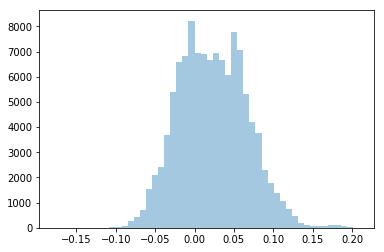

In [26]:
sns.distplot(corr12_inv, kde=False)

In [27]:
corr12_inv_ = pd.Series(corr12_inv, index=train_columns)

Filter duplicates and highly correlated features

In [45]:
filtered_corr12_inv_ = corr12_inv_[~corr12_inv_.duplicated()]

In [46]:
filtered_corr12_inv_.shape, corr12_inv_.shape

((38781,), (115233,))

In [47]:
np.min(filtered_corr12_inv_), np.max(filtered_corr12_inv_)

(-0.17786730107328005, 0.2088001575972251)

In [48]:
filtered_corr12_inv_[filtered_corr12_inv_ > 0.19].sort_values()

anatomy_rh_lateraloccipital_area x anatomy_3rd-Ventricle            0.190173
anatomy_lh_pericalcarine_thickness x anatomy_3rd-Ventricle          0.190343
anatomy_lh_medialorbitofrontal_thickness x anatomy_3rd-Ventricle    0.191050
anatomy_lh_lingual_thickness x anatomy_3rd-Ventricle                0.193350
anatomy_rh_precuneus_area x anatomy_3rd-Ventricle                   0.193866
anatomy_lh_superiorfrontal_thickness x anatomy_3rd-Ventricle        0.194641
anatomy_lh_superiortemporal_thickness x anatomy_3rd-Ventricle       0.196262
anatomy_rh_frontalpole_area x anatomy_3rd-Ventricle                 0.196816
anatomy_rh_superiortemporal_thickness x anatomy_3rd-Ventricle       0.197129
anatomy_lh_lateraloccipital_thickness x anatomy_3rd-Ventricle       0.197391
anatomy_rh_lingual_thickness x anatomy_3rd-Ventricle                0.198446
anatomy_rh_cuneus_thickness x anatomy_3rd-Ventricle                 0.199566
anatomy_rh_lateraloccipital_thickness x anatomy_3rd-Ventricle       0.199702

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


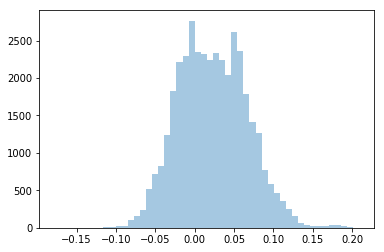

In [71]:
sns.distplot(filtered_corr12_inv_, kde=False)

Select features with positive correlation larger than a threshold

In [166]:
importance_threshold = 0.04
filtered_corr12_inv_[filtered_corr12_inv_.abs() > importance_threshold].shape

(16434,)

In [167]:
corr_selected_columns = filtered_corr12_inv_[filtered_corr12_inv_.abs() > importance_threshold].index.values.tolist()

In [168]:
len(corr_selected_columns)

16434

Save selected columns

In [81]:

np.savez_compressed('column_selections.npz', mi_selected_columns=mi_selected_columns, corr_selected_columns=corr_selected_columns)


### PCA feature extraction

In [19]:
from sklearn.decomposition import PCA

seed = 12
n_components = 500

pca = PCA(n_components=n_components, random_state=seed)

pca_data = pca.fit_transform(data2[train_columns].values)

In [20]:
pca_data.shape

(948, 500)

In [32]:
pca_cols = ["pca_{}".format(i) for i in range(n_components)]
pca_data_df = pd.DataFrame(pca_data, columns=pca_cols, index=data2.index)

pca_data_df = pd.concat([pca_data_df, data2['target']], axis=1)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


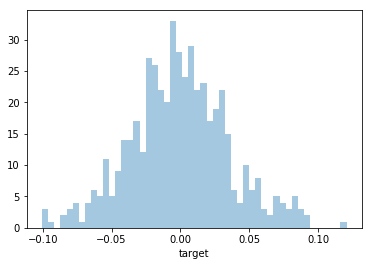

In [33]:
corr = pca_data_df.corr()

sns.distplot(corr.loc['target', pca_cols], bins=50, kde=False)

In [35]:
corr.loc['target', pca_cols][corr.loc['target', pca_cols].abs() > 0.09]

pca_0      0.090849
pca_53    -0.098639
pca_57     0.120529
pca_100   -0.100407
pca_158   -0.096223
pca_298   -0.093110
Name: target, dtype: float64

In [38]:
index = 57
sorted_components = np.argsort(np.abs(pca.components_[index]))[-10:]
pca.components_[index][sorted_components]

array([-0.15132935, -0.15143418, -0.15193145,  0.15193834, -0.1766986 ,
       -0.17898181, -0.17922183, -0.18032851,  0.334849  ,  0.33768118])

In [39]:
np.array(train_columns)[sorted_components]

array(['anatomy_lh_precentral_area 1/anatomy_non-WM-hypointensities',
       'anatomy_Right-Putamen 1/anatomy_5th-Ventricle',
       'anatomy_lh_precentral_area 1/anatomy_5th-Ventricle',
       'anatomy_rh_rostralmiddlefrontal_area 1/anatomy_non-WM-hypointensities',
       'anatomy_rh_precentral_area 1/anatomy_non-WM-hypointensities',
       'anatomy_rh_precentral_area 1/anatomy_5th-Ventricle',
       'anatomy_Left-Putamen 1/anatomy_5th-Ventricle',
       'anatomy_Left-Putamen 1/anatomy_non-WM-hypointensities',
       'anatomy_WM-hypointensities 1/anatomy_non-WM-hypointensities',
       'anatomy_WM-hypointensities 1/anatomy_5th-Ventricle'], dtype='<U95')

## Train a linear model 

In [78]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit


def evaluation(X, y):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=42).split(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=1, return_train_score=True,
                             n_jobs=1)
    
    return results

### Basic logistic regression 

In [79]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


class FeatureExtractor(BaseEstimator, TransformerMixin):
        
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return X_df
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = make_pipeline(StandardScaler(), 
                                 LogisticRegression())

    def fit(self, X, y):
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


Check `mi_selected_columns`

In [82]:
import numpy as np

results = evaluation(data2[mi_selected_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.627 +- 0.021 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.595 +- 0.017


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished


Check `corr_selected_columns`

In [80]:
import numpy as np

results = evaluation(data2[corr_selected_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.708 +- 0.022 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.653 +- 0.027


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   44.6s finished


A reference with feature ^ 2
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.637 +- 0.014 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.604 +- 0.014
```

Check `pca features`

In [211]:
import numpy as np

results = evaluation(pca_data_df[pca_cols], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.989 +- 0.007
Validation score ROC-AUC: 0.593 +- 0.018 

Training score accuracy: 0.950 +- 0.029
Validation score accuracy: 0.572 +- 0.015


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.2s finished


In [84]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(20, 10))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    if feature_names is not None:
        feature_names = np.array(feature_names)
        plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

### Feature importance of MI selected features

In [182]:
pipe = make_pipeline(FeatureExtractor(), Classifier())
pipe.fit(data2[mi_selected_columns], data2['target'])

Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor()), ('classifier', Classifier())])

In [185]:
log_reg1 = pipe.named_steps['classifier'].clf.named_steps['logisticregression']

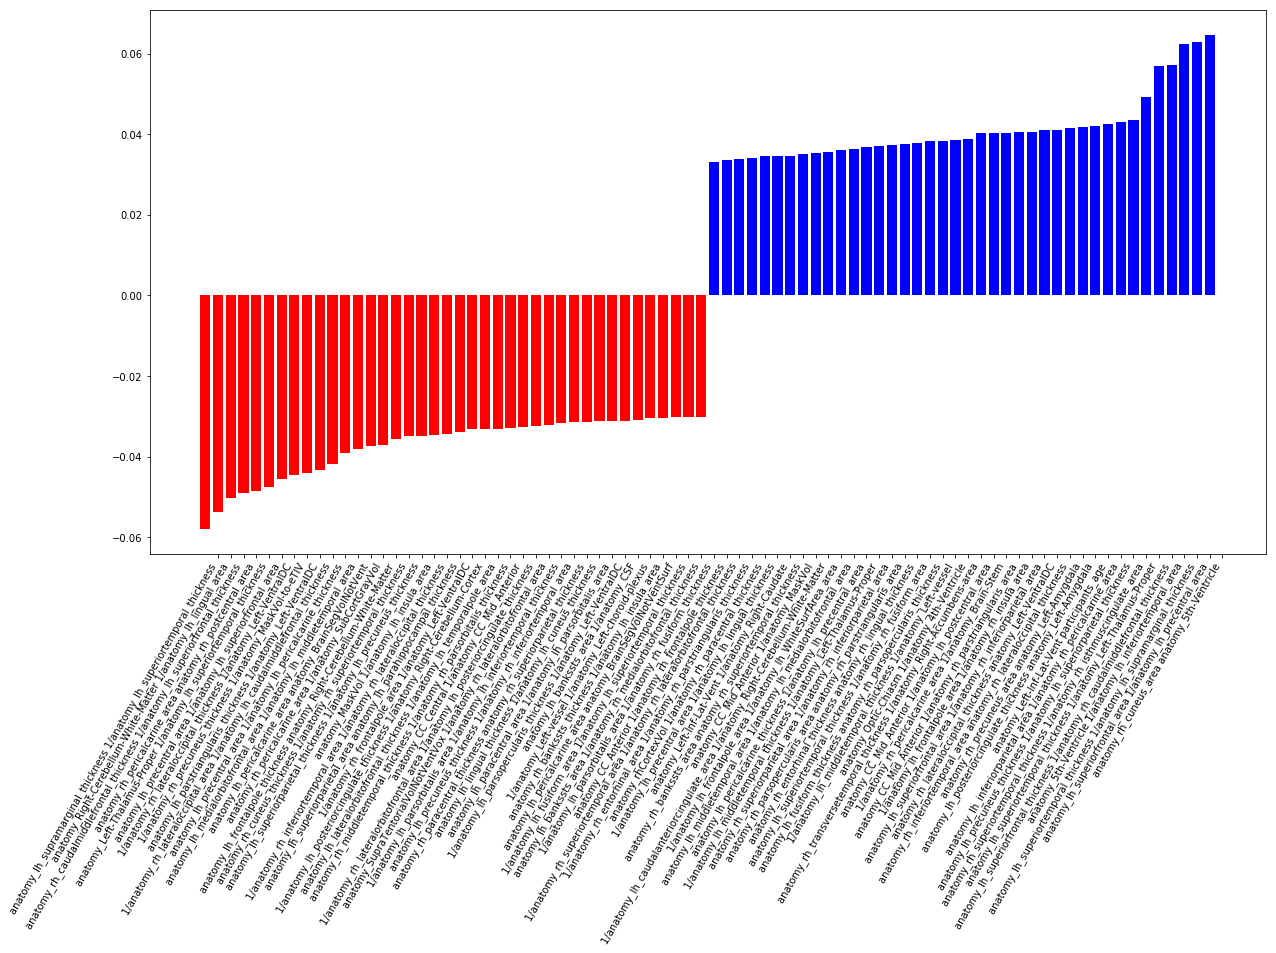

In [186]:
visualize_coefficients(log_reg1, feature_names=mi_selected_columns, n_top_features=40)

In [129]:
# coef = log_reg.coef_.ravel()
# poly_cols = poly_feature.get_feature_names(input_features=cols)
# np.savez_compressed("log_reg_coef_f_f2_1f_anatomy_participant_test_size=05.npz", coef=coef, poly_cols=poly_cols)

In [130]:
# log_reg_coef_2xfeatures = np.load("log_reg_coef_2xfeatures.npz")
# coef = log_reg_coef_2xfeatures['coef']
# poly_cols = log_reg_coef_2xfeatures['poly_cols']

In [187]:
coef1 = log_reg1.coef_.ravel()
positive_coefficients_1 = np.argsort(coef1)
negative_coefficients_1 = np.argsort(coef1)

In [188]:
coef1.min(), coef1.max(), np.abs(coef1).min()

(-0.057989707093967356, 0.0647044190404161, 1.67276576169317e-05)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


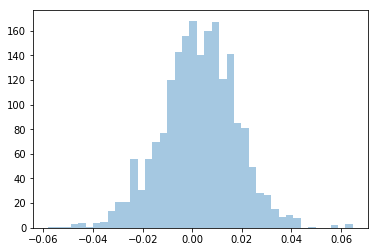

In [189]:
sns.distplot(coef1, kde=False)

In [205]:
n_top_features = 100

positive_coefficients = positive_coefficients_1[-n_top_features:]
negative_coefficients = negative_coefficients_1[:n_top_features]
interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])

top_mi_selected_columns = np.array(mi_selected_columns)[interesting_coefficients].tolist()

In [208]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
seed = 90
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(), 
                                LogisticRegressionCV(n_jobs=8, scoring="roc_auc", random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [209]:
results = evaluation(data2[top_mi_selected_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.894 +- 0.013
Validation score ROC-AUC: 0.730 +- 0.015 

Training score accuracy: 0.809 +- 0.019
Validation score accuracy: 0.673 +- 0.018


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.1s finished


90
```
Training score ROC-AUC: 0.894 +- 0.013
Validation score ROC-AUC: 0.730 +- 0.015 

Training score accuracy: 0.809 +- 0.019
Validation score accuracy: 0.673 +- 0.018
```

### Feature importance of Corr selected features

In [169]:
pipe = make_pipeline(FeatureExtractor(), Classifier())
pipe.fit(data2[corr_selected_columns], data2['target'])

Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor()), ('classifier', Classifier())])

In [170]:
log_reg2 = pipe.named_steps['classifier'].clf.named_steps['logisticregression']

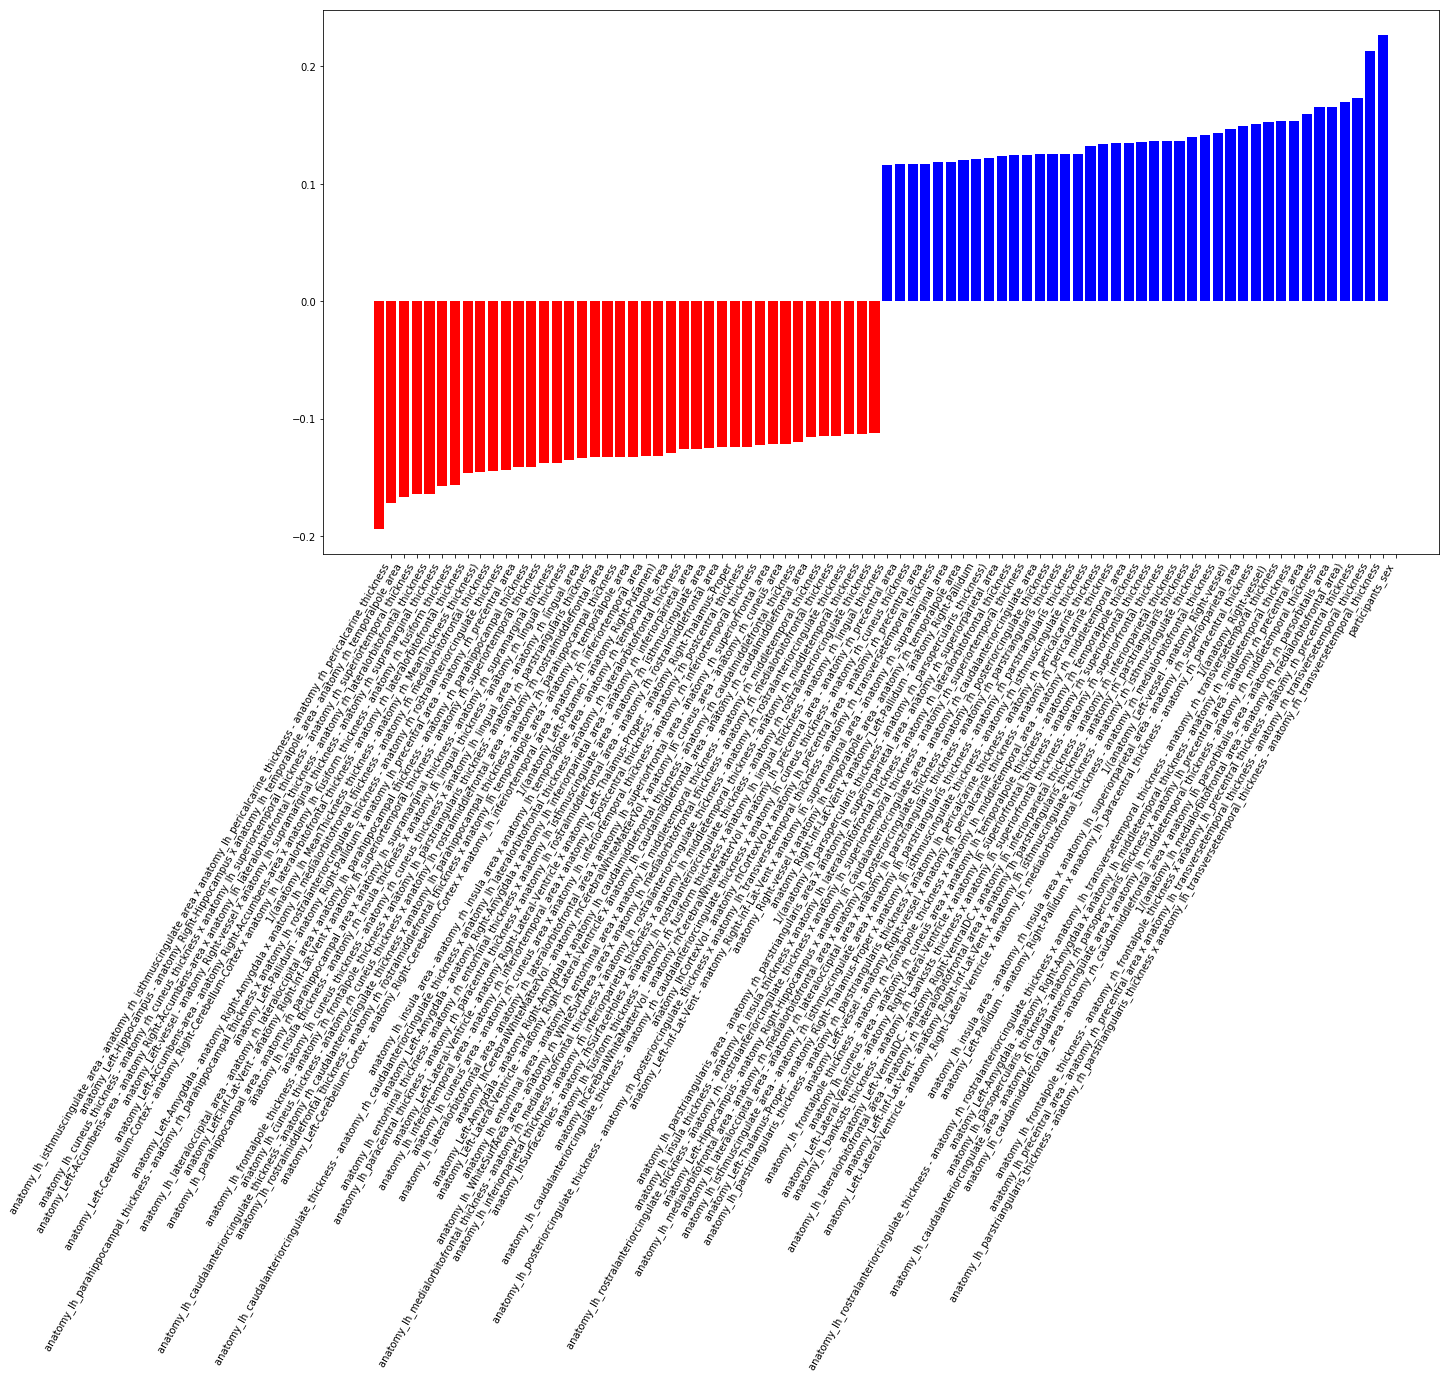

In [171]:
visualize_coefficients(log_reg2, feature_names=corr_selected_columns, n_top_features=40)

In [172]:
coef2 = log_reg2.coef_.ravel()
positive_coefficients_2 = np.argsort(coef2)
negative_coefficients_2 = np.argsort(coef2)

In [173]:
coef2.min(), coef2.max(), np.abs(coef2).min()

(-0.19397979428808496, 0.2270244634244378, 6.641131785701648e-07)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


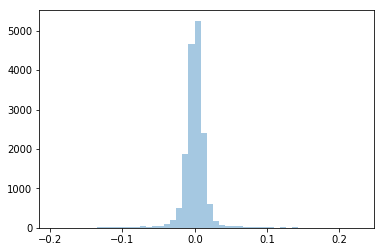

In [174]:
sns.distplot(coef2, kde=False)

In [190]:
n_top_features = 175

positive_coefficients = positive_coefficients_2[-n_top_features:]
negative_coefficients = negative_coefficients_2[:n_top_features]
interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])

top_corr_selected_columns = np.array(corr_selected_columns)[interesting_coefficients].tolist()

In [191]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
seed = 90
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(), 
                                LogisticRegressionCV(n_jobs=8, scoring="roc_auc", random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [192]:
results = evaluation(data2[top_corr_selected_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.986 +- 0.009
Validation score ROC-AUC: 0.812 +- 0.014 

Training score accuracy: 0.946 +- 0.028
Validation score accuracy: 0.732 +- 0.012


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.9s finished


175 (0.04 Corr threshold)
```
Training score ROC-AUC: 0.986 +- 0.009
Validation score ROC-AUC: 0.812 +- 0.014 

Training score accuracy: 0.946 +- 0.028
Validation score accuracy: 0.732 +- 0.012
```

160 (0.04 Corr threshold)
```
Training score ROC-AUC: 0.985 +- 0.011
Validation score ROC-AUC: 0.811 +- 0.009 

Training score accuracy: 0.944 +- 0.030
Validation score accuracy: 0.733 +- 0.011
```

140 (0.04 Corr threshold)
```
Training score ROC-AUC: 0.982 +- 0.012
Validation score ROC-AUC: 0.811 +- 0.012 

Training score accuracy: 0.937 +- 0.029
Validation score accuracy: 0.732 +- 0.015
```


140 (0.05 Corr threshold)
```
Training score ROC-AUC: 0.979 +- 0.018
Validation score ROC-AUC: 0.797 +- 0.006 

Training score accuracy: 0.933 +- 0.038
Validation score accuracy: 0.717 +- 0.010
```

### Feature importance of PCA features

In [238]:
pipe = make_pipeline(FeatureExtractor(), Classifier())
pipe.fit(pca_data_df[pca_cols], data2['target'])

Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor()), ('classifier', Classifier())])

In [240]:
log_reg3 = pipe.named_steps['classifier'].clf.named_steps['logisticregression']

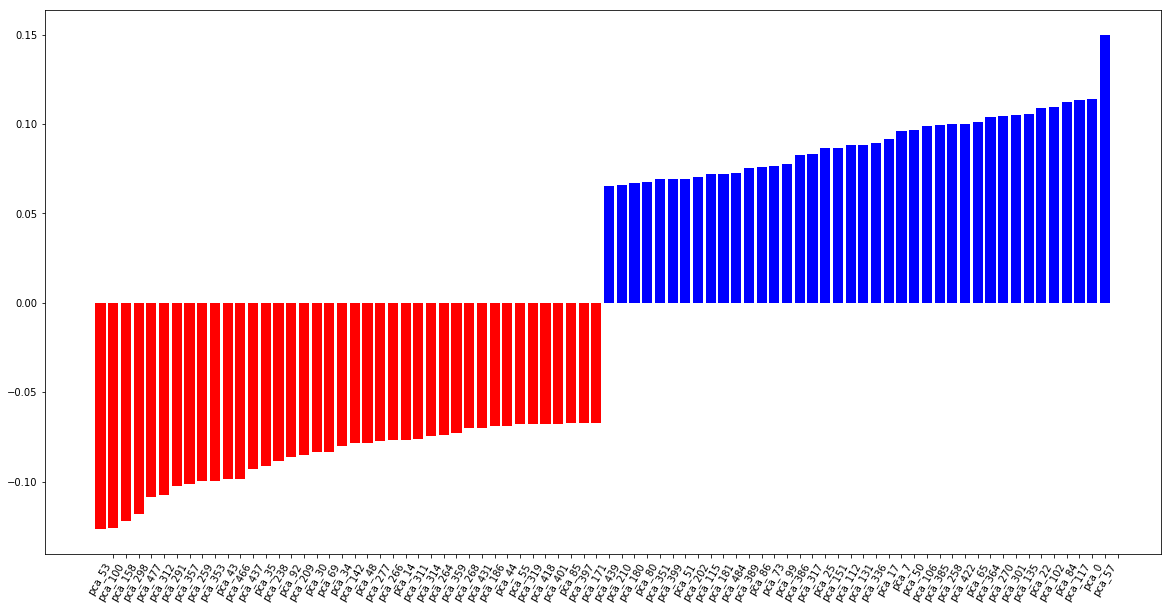

In [241]:
visualize_coefficients(log_reg3, feature_names=pca_cols, n_top_features=40)

In [243]:
coef3 = log_reg3.coef_.ravel()
positive_coefficients_3 = np.argsort(coef3)
negative_coefficients_3 = np.argsort(coef3)

In [244]:
coef3.min(), coef3.max(), np.abs(coef3).min()

(-0.12671464934363416, 0.14980653510843137, 2.9188812699494157e-05)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


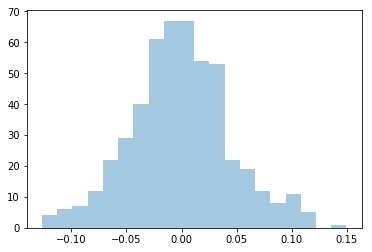

In [245]:
sns.distplot(coef3, kde=False)

In [274]:
n_top_features = 85

positive_coefficients = positive_coefficients_3[-n_top_features:]
negative_coefficients = negative_coefficients_3[:n_top_features]
interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])

top_pca_selected_columns = np.array(pca_cols)[interesting_coefficients].tolist()

In [275]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
seed = 90
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(), 
                                LogisticRegressionCV(n_jobs=8, scoring="roc_auc", random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [276]:
results = evaluation(pca_data_df[top_pca_selected_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.971 +- 0.008
Validation score ROC-AUC: 0.817 +- 0.021 

Training score accuracy: 0.904 +- 0.015
Validation score accuracy: 0.739 +- 0.018


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.1s finished


95
```
Training score ROC-AUC: 0.971 +- 0.008
Validation score ROC-AUC: 0.817 +- 0.021 

Training score accuracy: 0.904 +- 0.015
Validation score accuracy: 0.739 +- 0.018
```

Mix of best

In [316]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
seed = 90
        

class FeatureExtractor(BaseEstimator, TransformerMixin):
        
    def fit(self, X_df, y):
        return self

    def transform(self, X):
        # get only the anatomical information
#         l1 = len(top_pca_selected_columns)
#         l2 = len(top_mi_selected_columns) 
#         return X[:, :l1], X[:, l1:l2], X[:, l2:]
        l1 = len(top_pca_selected_columns)
        return X[:, :l1], X[:, l1:]    
    
    
class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe1_cv = make_pipeline(StandardScaler(), 
                                 LogisticRegressionCV(n_jobs=8, scoring="roc_auc", random_state=seed))
        pipe1_cv.fit(X[0], y)
        best_C1 = pipe1_cv.named_steps['logisticregressioncv'].C_[0]
        
        pipe2_cv = make_pipeline(StandardScaler(), 
                                 LogisticRegressionCV(n_jobs=8, scoring="roc_auc", random_state=seed))
        pipe2_cv.fit(X[1], y)
        best_C2 = pipe2_cv.named_steps['logisticregressioncv'].C_[0]

#         pipe3_cv = make_pipeline(StandardScaler(), 
#                                  LogisticRegressionCV(n_jobs=8, scoring="roc_auc", random_state=seed))
#         pipe3_cv.fit(X[2], y)
#         best_C3 = pipe3_cv.named_steps['logisticregressioncv'].C_[0]
        
        
        self.clf1 = make_pipeline(StandardScaler(), LogisticRegression(C=best_C1, random_state=seed))
        self.clf1.fit(X[0], y)

        self.clf2 = make_pipeline(StandardScaler(), LogisticRegression(C=best_C2, random_state=seed))
        self.clf2.fit(X[1], y)

#         self.clf3 = make_pipeline(StandardScaler(), LogisticRegression(C=best_C3, random_state=seed))
#         self.clf3.fit(X[2], y)
                
        return self
        
    def predict(self, X):        
        probas = self.predict_proba(X)[:, 1]
        preds = (probas > 0.5).astype(np.int)         
        return preds

    def predict_proba(self, X):
        p1 = self.clf1.predict_proba(X[0])
        p2 = self.clf2.predict_proba(X[1])
#         p3 = self.clf3.predict_proba(X[2])
        return 0.7 * p1 + 0.30 * p2 # + 0.0 * p3

In [317]:
X = np.concatenate(
    [
        pca_data_df[top_pca_selected_columns].values,
        data2[top_corr_selected_columns].values,
#         data2[top_mi_selected_columns].values
    ],
    axis=1
)

results = evaluation(X, data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.971 +- 0.010
Validation score ROC-AUC: 0.829 +- 0.019 

Training score accuracy: 0.904 +- 0.014
Validation score accuracy: 0.753 +- 0.015


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.7s finished


70 - 30 - 0
```
Training score ROC-AUC: 0.971 +- 0.010
Validation score ROC-AUC: 0.829 +- 0.019 

Training score accuracy: 0.904 +- 0.014
Validation score accuracy: 0.753 +- 0.015
```

In [ ]:
top_corr_selected_columns

### Basic logistic regression on poly features

In [50]:
X_df = data_train
for fname in topk_2xfeature_names:
    if " " in fname:
        X_df.loc[:, fname] = 0.0
        f1, f2 = fname.split(" ")
        X_df.loc[:, fname] = X_df[f1] * X_df[f2]

In [51]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y):                
        return self

    def transform(self, X_df):
        # create polynomial features:
#         if X_df['participants_sex'].unique().dtype != int:
#             X_df['participants_sex'] = X_df['participants_sex'].map({'F': 0, 'M': 1}) 
#         for fname in topk_2xfeature_names:
#             if " " in fname:
#                 X_df.loc[:, fname] = 0.0
#                 f1, f2 = fname.split(" ")
#                 X_df.loc[:, fname] = X_df[f1] * X_df[f2]
        return X_df[topk_2xfeature_names + topk_feature_names]
    
    
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
seed = 100
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(), 
                                LogisticRegressionCV(n_jobs=8, scoring="roc_auc", random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


In [52]:
import numpy as np

results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.760 +- 0.022 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.694 +- 0.016


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   30.1s finished


Find optimal number of features

In [104]:
n_top_features = 1000
positive_coefficients = np.argsort(coef)[-n_top_features:]
negative_coefficients = np.argsort(coef)[:n_top_features]
interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
topk_2xfeature_names = np.array(poly_cols)[interesting_coefficients].tolist()


X_df = data_train
for fname in topk_2xfeature_names:
    if " " in fname:
        X_df.loc[:, fname] = 0.0
        f1, f2 = fname.split(" ")
        X_df.loc[:, fname] = X_df[f1] * X_df[f2]

In [102]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [113]:
positive_coefficients = np.argsort(coef)
negative_coefficients = np.argsort(coef)


class _FeatureExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, features):
        self.features = features
    
    def fit(self, X_df, y):                
        return self

    def transform(self, X_df):
        return X_df[self.features]

    
def _evaluation(X, y, features):
    pipe = make_pipeline(_FeatureExtractor(features), Classifier())
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=42).split(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=1, return_train_score=True,
                             n_jobs=1)
    
    return results


def score(params):
    num_features = params['num_features']
    
    print("Trial: num_features: {}".format(num_features), end=" -> ")
    
    n_top_features = num_features
    positive_coefficients_ = positive_coefficients[-n_top_features:]
    negative_coefficients_ = negative_coefficients[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients_, positive_coefficients_])
    topk_2xfeature_names = np.array(poly_cols)[interesting_coefficients].tolist()
        
    results = _evaluation(data_train, labels_train, topk_2xfeature_names + topk_feature_names)
    roc = np.mean(results['test_roc_auc']) 
    acc = np.mean(results['test_accuracy'])
    res = roc + acc
    print("Score: roc = {} | acc = {}".format(roc, acc))
    return {'loss': 2.0 - res, 'status': STATUS_OK}
    
    
def get_num_features():
    return hp.randint('num_features', 750) + 150
    
    
def optimize(trials, max_evals):
    params = {'num_features': get_num_features()}
    best = fmin(score, params, algo=tpe.suggest, trials=trials, max_evals=max_evals)    
    return best


trials = Trials()
best_num_features = optimize(trials, max_evals=50)
best_num_features

Trial: num_features: 644 -> Score: roc = 0.7835549114737572 | acc = 0.7120567375886525
Trial: num_features: 186 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.9s finished


Score: roc = 0.7466561653329973 | acc = 0.6828014184397164
Trial: num_features: 605 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.8s finished


Score: roc = 0.783729443639342 | acc = 0.7148936170212765
Trial: num_features: 350 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.5s finished


Score: roc = 0.7749593598386995 | acc = 0.7070921985815602
Trial: num_features: 408 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.7s finished


Score: roc = 0.7816583706130679 | acc = 0.7122340425531914
Trial: num_features: 629 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.0s finished


Score: roc = 0.7852416356877324 | acc = 0.7152482269503546
Trial: num_features: 395 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.1s finished


Score: roc = 0.7802665238485287 | acc = 0.7101063829787234
Trial: num_features: 711 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.3s finished


Score: roc = 0.7889150022052801 | acc = 0.7145390070921986
Trial: num_features: 547 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.3s finished


Score: roc = 0.7863039506017264 | acc = 0.7157801418439717
Trial: num_features: 773 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.2s finished


Score: roc = 0.7863726293239243 | acc = 0.7145390070921985
Trial: num_features: 769 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.0s finished


Score: roc = 0.7836330413962573 | acc = 0.7115248226950355
Trial: num_features: 232 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.6s finished


Score: roc = 0.756112406275597 | acc = 0.6920212765957447
Trial: num_features: 875 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.5s finished


Score: roc = 0.7857601915443262 | acc = 0.7143617021276596
Trial: num_features: 606 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.3s finished


Score: roc = 0.7834131434692206 | acc = 0.7148936170212767
Trial: num_features: 425 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.0s finished


Score: roc = 0.7814063386050029 | acc = 0.7088652482269503
Trial: num_features: 452 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.4s finished


Score: roc = 0.7843992187007749 | acc = 0.7111702127659574
Trial: num_features: 602 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.0s finished


Score: roc = 0.7865981979711424 | acc = 0.7170212765957447
Trial: num_features: 846 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.7s finished


Score: roc = 0.7872345787915066 | acc = 0.7161347517730496
Trial: num_features: 520 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.9s finished


Score: roc = 0.7847848276731144 | acc = 0.7152482269503546
Trial: num_features: 228 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.3s finished


Score: roc = 0.7537981223615399 | acc = 0.6906028368794326
Trial: num_features: 156 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.4s finished


Score: roc = 0.7433148509860753 | acc = 0.677836879432624
Trial: num_features: 518 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.0s finished


Score: roc = 0.7827988154495621 | acc = 0.7118794326241135
Trial: num_features: 807 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.6s finished


Score: roc = 0.7866523848528764 | acc = 0.7131205673758865
Trial: num_features: 437 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.2s finished


Score: roc = 0.7837149517988784 | acc = 0.7118794326241135
Trial: num_features: 602 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.9s finished


Score: roc = 0.7865981979711424 | acc = 0.7170212765957447
Trial: num_features: 585 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.5s finished


Score: roc = 0.7851490139247685 | acc = 0.7115248226950355
Trial: num_features: 550 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.1s finished


Score: roc = 0.7841963329342827 | acc = 0.7127659574468085
Trial: num_features: 602 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.7s finished


Score: roc = 0.7865981979711424 | acc = 0.7170212765957447
Trial: num_features: 310 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.3s finished


Score: roc = 0.7663656984437023 | acc = 0.6957446808510637
Trial: num_features: 166 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.5s finished


Score: roc = 0.7435486106735555 | acc = 0.6764184397163121
Trial: num_features: 284 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.3s finished


Score: roc = 0.7614932896477853 | acc = 0.6904255319148935
Trial: num_features: 276 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.1s finished


Score: roc = 0.7601335769642745 | acc = 0.6890070921985816
Trial: num_features: 612 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.5s finished


Score: roc = 0.7843254993384161 | acc = 0.7177304964539009
Trial: num_features: 341 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.1s finished


Score: roc = 0.7740690567702098 | acc = 0.7053191489361701
Trial: num_features: 488 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.8s finished


Score: roc = 0.7838806628441812 | acc = 0.7086879432624114
Trial: num_features: 169 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.1s finished


Score: roc = 0.7455050091361604 | acc = 0.6810283687943264
Trial: num_features: 762 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.3s finished


Score: roc = 0.7849310062377922 | acc = 0.7120567375886525
Trial: num_features: 619 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.7s finished


Score: roc = 0.7841578980530527 | acc = 0.7157801418439715
Trial: num_features: 255 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.4s finished


Score: roc = 0.7568615714195703 | acc = 0.6895390070921985
Trial: num_features: 562 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.0s finished


Score: roc = 0.7833129607460148 | acc = 0.7140070921985815
Trial: num_features: 254 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.9s finished


Score: roc = 0.7578741100119715 | acc = 0.6907801418439716
Trial: num_features: 743 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.2s finished


Score: roc = 0.7872465503118896 | acc = 0.7129432624113475
Trial: num_features: 833 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.2s finished


Score: roc = 0.7880788860185244 | acc = 0.7148936170212765
Trial: num_features: 515 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.2s finished


Score: roc = 0.7839984878079516 | acc = 0.7134751773049646
Trial: num_features: 181 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.0s finished


Score: roc = 0.7469371810219898 | acc = 0.6833333333333333
Trial: num_features: 688 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.4s finished


Score: roc = 0.7851773675256758 | acc = 0.7122340425531914
Trial: num_features: 806 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.3s finished


Score: roc = 0.7854640539348497 | acc = 0.7122340425531914
Trial: num_features: 836 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.4s finished


Score: roc = 0.788337218826791 | acc = 0.7152482269503546
Trial: num_features: 831 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.8s finished


Score: roc = 0.7863820805242265 | acc = 0.7129432624113475
Trial: num_features: 194 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.8s finished


Score: roc = 0.7443670846197467 | acc = 0.6799645390070922
Trial: num_features: 332 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.5s finished


Score: roc = 0.7705380883372188 | acc = 0.700354609929078
Trial: num_features: 266 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.1s finished


Score: roc = 0.7579194757734232 | acc = 0.6879432624113474
Trial: num_features: 285 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.2s finished


Score: roc = 0.7622348938315165 | acc = 0.6907801418439716
Trial: num_features: 614 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.6s finished


Score: roc = 0.7825215802406906 | acc = 0.7154255319148938
Trial: num_features: 552 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.3s finished


Score: roc = 0.7835870455547854 | acc = 0.7161347517730496
Trial: num_features: 380 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.4s finished


Score: roc = 0.7773895784764665 | acc = 0.7074468085106382
Trial: num_features: 357 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.0s finished


Score: roc = 0.776736815575578 | acc = 0.7079787234042553
Trial: num_features: 324 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.0s finished


Score: roc = 0.7660695608342261 | acc = 0.6943262411347517
Trial: num_features: 618 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.8s finished


Score: roc = 0.7836702161174469 | acc = 0.7143617021276596
Trial: num_features: 473 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.7s finished


Score: roc = 0.7835271879528699 | acc = 0.7085106382978723
Trial: num_features: 892 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.0s finished


Score: roc = 0.7858276101064835 | acc = 0.7148936170212766
Trial: num_features: 653 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   25.9s finished


Score: roc = 0.7832373511435952 | acc = 0.7127659574468086
Trial: num_features: 236 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.4s finished


Score: roc = 0.7587335391594733 | acc = 0.6891843971631205
Trial: num_features: 379 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.9s finished


Score: roc = 0.7787203074790499 | acc = 0.7069148936170213
Trial: num_features: 202 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.8s finished


Score: roc = 0.746930250141768 | acc = 0.6849290780141845
Trial: num_features: 531 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.2s finished


Score: roc = 0.7858042971457374 | acc = 0.7166666666666667
Trial: num_features: 519 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.4s finished


Score: roc = 0.78453531598513 | acc = 0.7129432624113475
Trial: num_features: 602 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.5s finished


Score: roc = 0.7865981979711424 | acc = 0.7170212765957447
Trial: num_features: 208 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.5s finished


Score: roc = 0.7457375086636002 | acc = 0.6822695035460994
Trial: num_features: 459 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.2s finished


Score: roc = 0.7801631907252221 | acc = 0.7058510638297872
Trial: num_features: 334 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.1s finished


Score: roc = 0.7728863965723647 | acc = 0.701063829787234
Trial: num_features: 702 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.8s finished


Score: roc = 0.787430533677777 | acc = 0.7099290780141843
Trial: num_features: 602 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.9s finished


Score: roc = 0.7865981979711424 | acc = 0.7170212765957447
Trial: num_features: 720 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.4s finished


Score: roc = 0.7868388885388444 | acc = 0.7134751773049646
Trial: num_features: 237 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.6s finished


Score: roc = 0.757903093692899 | acc = 0.6895390070921985
Trial: num_features: 590 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.8s finished


Score: roc = 0.785972528511121 | acc = 0.7131205673758865
Trial: num_features: 602 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.4s finished


Score: roc = 0.7865981979711424 | acc = 0.7170212765957447
Trial: num_features: 649 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.2s finished


Score: roc = 0.7849184046373889 | acc = 0.7159574468085107
Trial: num_features: 314 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.9s finished


Score: roc = 0.7655062692962006 | acc = 0.6946808510638297
Trial: num_features: 462 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.3s finished


Score: roc = 0.7841786906937182 | acc = 0.7085106382978723
Trial: num_features: 187 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.7s finished


Score: roc = 0.7465314094890051 | acc = 0.6836879432624114
Trial: num_features: 751 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.7s finished


Score: roc = 0.7886314661962068 | acc = 0.7148936170212766
Trial: num_features: 463 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.6s finished


Score: roc = 0.7827383277676265 | acc = 0.7076241134751773
Trial: num_features: 512 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.7s finished


Score: roc = 0.7848598071955137 | acc = 0.7111702127659574
Trial: num_features: 779 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.9s finished


Score: roc = 0.7853386680108373 | acc = 0.7120567375886526
Trial: num_features: 626 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.7s finished


Score: roc = 0.7845201940646462 | acc = 0.7127659574468086
Trial: num_features: 602 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.6s finished


Score: roc = 0.7865981979711424 | acc = 0.7170212765957447
Trial: num_features: 791 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.4s finished


Score: roc = 0.7879478293743305 | acc = 0.7148936170212765
Trial: num_features: 450 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.7s finished


Score: roc = 0.7851565748850104 | acc = 0.7093971631205673
Trial: num_features: 436 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.4s finished


Score: roc = 0.7824547917585533 | acc = 0.7081560283687943
Trial: num_features: 886 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.7s finished


Score: roc = 0.7862346417995085 | acc = 0.7148936170212765
Trial: num_features: 203 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.1s finished


Score: roc = 0.7449404574380947 | acc = 0.6826241134751774
Trial: num_features: 877 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.0s finished


Score: roc = 0.7847022871904732 | acc = 0.7138297872340427
Trial: num_features: 885 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.3s finished


Score: roc = 0.785566126898116 | acc = 0.7163120567375887
Trial: num_features: 542 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   25.0s finished


Score: roc = 0.784821372314284 | acc = 0.7143617021276596
Trial: num_features: 339 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.3s finished


Score: roc = 0.7735983869951484 | acc = 0.7037234042553191
Trial: num_features: 712 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.2s finished


Score: roc = 0.7882288450633231 | acc = 0.7147163120567376
Trial: num_features: 692 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.0s finished


Score: roc = 0.7851408228845063 | acc = 0.7113475177304964
Trial: num_features: 598 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.3s finished


Score: roc = 0.7869913679037237 | acc = 0.7140070921985815
Trial: num_features: 220 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.8s finished


Score: roc = 0.7537464557998866 | acc = 0.6893617021276596
Trial: num_features: 329 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.8s finished


Score: roc = 0.7711108310755466 | acc = 0.699822695035461
Trial: num_features: 464 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.1s finished


Score: roc = 0.7823533488753072 | acc = 0.7069148936170213
Trial: num_features: 584 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.3s finished


Score: roc = 0.7840407031693024 | acc = 0.7092198581560283
Trial: num_features: 812 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.0s finished


Score: roc = 0.7885671980341504 | acc = 0.7152482269503546
Trial: num_features: 812 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.0s finished


Score: roc = 0.7885671980341504 | acc = 0.7152482269503546
Trial: num_features: 747 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.2s finished


Score: roc = 0.787430533677777 | acc = 0.7152482269503546
Trial: num_features: 631 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.8s finished


Score: roc = 0.7849820427194254 | acc = 0.7170212765957447
Trial: num_features: 219 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.3s finished


Score: roc = 0.7536721063575074 | acc = 0.6900709219858155
Trial: num_features: 509 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.7s finished


Score: roc = 0.7845573687858358 | acc = 0.7122340425531914
Trial: num_features: 407 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.8s finished


Score: roc = 0.7816508096528259 | acc = 0.7093971631205673
Trial: num_features: 274 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.7s finished


Score: roc = 0.7618335328586731 | acc = 0.6920212765957446
Trial: num_features: 355 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.3s finished


Score: roc = 0.7757891752252537 | acc = 0.7083333333333334
Trial: num_features: 532 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.9s finished


Score: roc = 0.7839310692457943 | acc = 0.7145390070921985
Trial: num_features: 788 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.2s finished


Score: roc = 0.7870770587864659 | acc = 0.7156028368794326
Trial: num_features: 182 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.0s finished


Score: roc = 0.747387058156386 | acc = 0.6835106382978724
Trial: num_features: 812 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.2s finished


Score: roc = 0.7885671980341504 | acc = 0.7152482269503546
Trial: num_features: 850 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.6s finished


Score: roc = 0.787089030306849 | acc = 0.7140070921985816
Trial: num_features: 715 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.8s finished


Score: roc = 0.7852554974481759 | acc = 0.7108156028368795
Trial: num_features: 857 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.2s finished


Score: roc = 0.7856625291412009 | acc = 0.7131205673758865
Trial: num_features: 812 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.7s finished


Score: roc = 0.7885671980341504 | acc = 0.7152482269503546
Trial: num_features: 205 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.8s finished


Score: roc = 0.7443362106987588 | acc = 0.6847517730496454
Trial: num_features: 215 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.0s finished


Score: roc = 0.7495854073467331 | acc = 0.6820921985815602
Trial: num_features: 758 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.7s finished


Score: roc = 0.7885249826727995 | acc = 0.7168439716312057
Trial: num_features: 198 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.0s finished


Score: roc = 0.7468388885388444 | acc = 0.6819148936170214
Trial: num_features: 322 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.0s finished


Score: roc = 0.7677191103270115 | acc = 0.6969858156028368
Trial: num_features: 789 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.3s finished


Score: roc = 0.7867059416545902 | acc = 0.7136524822695035
Trial: num_features: 758 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.3s finished


Score: roc = 0.7885249826727995 | acc = 0.7168439716312057
Trial: num_features: 817 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.0s finished


Score: roc = 0.789012034528385 | acc = 0.7166666666666667
Trial: num_features: 811 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.0s finished


Score: roc = 0.7886932140381828 | acc = 0.7157801418439715
Trial: num_features: 646 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.7s finished


Score: roc = 0.7852542372881356 | acc = 0.7141843971631205
Trial: num_features: 822 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.7s finished


Score: roc = 0.7893610988595553 | acc = 0.7173758865248226
Trial: num_features: 693 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.2s finished


Score: roc = 0.7855598260979144 | acc = 0.7115248226950354
Trial: num_features: 778 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.2s finished


Score: roc = 0.7868262869384411 | acc = 0.7140070921985816
Trial: num_features: 430 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.6s finished


Score: roc = 0.7810087581122803 | acc = 0.7062056737588652
Trial: num_features: 554 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.4s finished


Score: roc = 0.7826463360846827 | acc = 0.7125886524822694
Trial: num_features: 630 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.1s finished


Score: roc = 0.7848932014365825 | acc = 0.7150709219858157
Trial: num_features: 157 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.9s finished


Score: roc = 0.7431989162623653 | acc = 0.6787234042553192
Trial: num_features: 841 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.7s finished


Score: roc = 0.7876088463234832 | acc = 0.7159574468085107
Trial: num_features: 438 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.9s finished


Score: roc = 0.7824560519185937 | acc = 0.7115248226950355
Trial: num_features: 569 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.7s finished


Score: roc = 0.7849511687984373 | acc = 0.7141843971631204
Trial: num_features: 837 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.3s finished


Score: roc = 0.787786528889169 | acc = 0.7156028368794326
Trial: num_features: 469 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.3s finished


Score: roc = 0.7816596307731082 | acc = 0.7058510638297872
Trial: num_features: 855 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.9s finished


Score: roc = 0.78542624913364 | acc = 0.7138297872340426
Trial: num_features: 707 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.7s finished


Score: roc = 0.7872667128725348 | acc = 0.7113475177304964
Trial: num_features: 824 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.6s finished


Score: roc = 0.7861508411568269 | acc = 0.7156028368794327
Trial: num_features: 758 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.1s finished


Score: roc = 0.7885249826727995 | acc = 0.7168439716312057
Trial: num_features: 587 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.6s finished


Score: roc = 0.7828826160922436 | acc = 0.7092198581560283
Trial: num_features: 523 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.7s finished


Score: roc = 0.7844288324617226 | acc = 0.7124113475177305
Trial: num_features: 758 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.8s finished


Score: roc = 0.7885249826727995 | acc = 0.7168439716312057
Trial: num_features: 822 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.0s finished


Score: roc = 0.7893610988595553 | acc = 0.7173758865248226
Trial: num_features: 262 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.6s finished


Score: roc = 0.7574210824774746 | acc = 0.6911347517730496
Trial: num_features: 832 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.7s finished


Score: roc = 0.7878892319324555 | acc = 0.7145390070921986
Trial: num_features: 361 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.0s finished


Score: roc = 0.7768495998991872 | acc = 0.7090425531914893
Trial: num_features: 575 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.4s finished


Score: roc = 0.7856795413017454 | acc = 0.7150709219858156
Trial: num_features: 400 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.7s finished


Score: roc = 0.7799426627181651 | acc = 0.7113475177304964
Trial: num_features: 257 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.5s finished


Score: roc = 0.7585917711549367 | acc = 0.6895390070921985
Trial: num_features: 858 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.0s finished


Score: roc = 0.7861905361980972 | acc = 0.7129432624113475
Trial: num_features: 382 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.5s finished


Score: roc = 0.7787505513200177 | acc = 0.7069148936170213
Trial: num_features: 678 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.2s finished


Score: roc = 0.7838315166026085 | acc = 0.7117021276595745
Trial: num_features: 229 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.7s finished


Score: roc = 0.7536481633167413 | acc = 0.6902482269503546
Trial: num_features: 887 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.9s finished


Score: roc = 0.7859429147501733 | acc = 0.7173758865248228
Trial: num_features: 216 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   26.3s finished
Process ForkPoolWorker-13913:
Process ForkPoolWorker-13914:
Traceback (most recent call last):
Process ForkPoolWorker-13912:
Traceback (most recent call last):
  File "/opt/conda/envs/rampwf/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


KeyboardInterrupt: 

In [119]:
best_num_features = 822

n_top_features = best_num_features
positive_coefficients = np.argsort(coef)[-n_top_features:]
negative_coefficients = np.argsort(coef)[:n_top_features]
interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
topk_2xfeature_names = np.array(poly_cols)[interesting_coefficients].tolist()
print(len(topk_2xfeature_names))

class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y):                
        return self

    def transform(self, X_df):
        return X_df[topk_2xfeature_names + topk_feature_names]


results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

1644
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.789 +- 0.015 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.717 +- 0.017


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   26.0s finished


## Test size = 0.5

### Anatomy + Participant

715
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.785 +- 0.016 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.711 +- 0.018
```


700
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.788 +- 0.015 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.711 +- 0.015
```

650
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.785 +- 0.016 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.710 +- 0.017
```


625
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.784 +- 0.017 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.714 +- 0.017
```


600
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.787 +- 0.017 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.718 +- 0.017
```


575
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.786 +- 0.016 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.715 +- 0.015
```


550
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.784 +- 0.012 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.713 +- 0.010
```

500
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.785 +- 0.013 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.712 +- 0.017
```

450
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.785 +- 0.015 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.709 +- 0.020
```


250
```
Training score ROC-AUC: 0.998 +- 0.005
Validation score ROC-AUC: 0.756 +- 0.014 

Training score accuracy: 0.994 +- 0.019
Validation score accuracy: 0.691 +- 0.019
```



120
```
Training score ROC-AUC: 0.989 +- 0.020
Validation score ROC-AUC: 0.739 +- 0.019 

Training score accuracy: 0.969 +- 0.046
Validation score accuracy: 0.677 +- 0.017
```

## Test size = 0.2

#### Anatomy + Participant

715
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.899 +- 0.018 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.812 +- 0.021
```


700
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.899 +- 0.018 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.820 +- 0.021
```

695
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.896 +- 0.017 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.811 +- 0.022
```


675
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.895 +- 0.018 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.820 +- 0.020
```


650
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.892 +- 0.017 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.821 +- 0.020
```


625
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.891 +- 0.016 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.820 +- 0.021
```


500
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.884 +- 0.017 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.819 +- 0.020
```


150
```
Training score ROC-AUC: 0.982 +- 0.015
Validation score ROC-AUC: 0.797 +- 0.014 

Training score accuracy: 0.935 +- 0.032
Validation score accuracy: 0.712 +- 0.022
```


#### Anatomy only

650
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.892 +- 0.024 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.822 +- 0.022
```


600
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.889 +- 0.024 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.810 +- 0.029
```


500
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.886 +- 0.020 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.802 +- 0.020
```


400
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.876 +- 0.020 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.799 +- 0.024
```


300
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.853 +- 0.022 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.769 +- 0.023
```


100
```
Training score ROC-AUC: 0.945 +- 0.014
Validation score ROC-AUC: 0.754 +- 0.019 

Training score accuracy: 0.873 +- 0.016
Validation score accuracy: 0.685 +- 0.023
```


baseline 1x features:
```
Training score ROC-AUC: 0.819 +- 0.004
Validation score ROC-AUC: 0.741 +- 0.018 

Training score accuracy: 0.744 +- 0.008
Validation score accuracy: 0.676 +- 0.018
```

In [66]:
len(topk_feature_names), len(topk_2xfeature_names)

(82, 1300)

Check coeff importance:

In [67]:
pipe = make_pipeline(FeatureExtractor(), Classifier())

In [68]:
pipe.fit(data_train, labels_train)

Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor()), ('classifier', Classifier())])

In [69]:
log_reg = pipe.named_steps['classifier'].clf.named_steps['logisticregression']

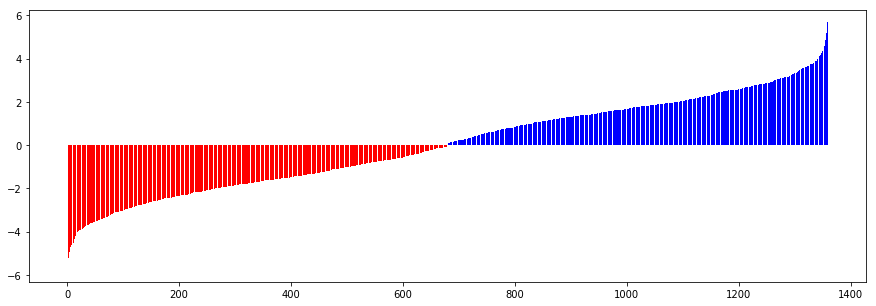

In [84]:
visualize_coefficients(log_reg, feature_names=None, n_top_features=680)

In [123]:
len(topk_2xfeature_names)

1644

In [347]:
print("[", end="")
for f in top_corr_selected_columns:
    print("\"{}\"".format(f), end=", ")
print("]")

["anatomy_WM-hypointensities participants_sex", "anatomy_3rd-Ventricle 1/anatomy_lh_lingual_area", "anatomy_lh_bankssts_area anatomy_3rd-Ventricle", "anatomy_lh_entorhinal_area participants_sex", "anatomy_3rd-Ventricle anatomy_Right-Cerebellum-White-Matter", "anatomy_rh_lateralorbitofrontal_thickness anatomy_Right-Hippocampus", "anatomy_rh_middletemporal_thickness anatomy_Right-Hippocampus", "anatomy_rh_lateralorbitofrontal_thickness anatomy_Left-VentralDC", "anatomy_3rd-Ventricle 1/anatomy_Right-Cerebellum-Cortex", "anatomy_rh_pericalcarine_area anatomy_Left-Inf-Lat-Vent", "anatomy_rh_lateralorbitofrontal_thickness anatomy_Left-Amygdala", "anatomy_rh_lateralorbitofrontal_thickness anatomy_Right-Amygdala", "anatomy_rh_precuneus_area 1/anatomy_rh_lateralorbitofrontal_area", "participants_sex 1/anatomy_lh_inferiortemporal_area", "anatomy_rh_precuneus_area anatomy_rh_lateralorbitofrontal_thickness", "anatomy_Right-Hippocampus 1/anatomy_Right-Hippocampus", "anatomy_3rd-Ventricle 1/anatomy_